In [6]:
# Whenever using external files along with Ipython use autoreload. 
# It will reload the external files every time before executing any code in IPython.
%load_ext autoreload
%autoreload 2

## Numerical Derivative

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

f(3)

20

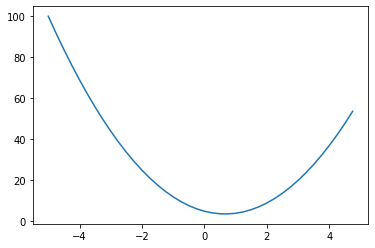

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.00000001
x = 2
(f(x+h) - f(x)) / h

7.999999951380232

## Value Class

In [2]:
from micrograd import engine

a = engine.Value(2.0, label='a')
b = engine.Value(-3.0, label='b')
c = engine.Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = engine.Value(-2.0, label='f')
L = d*f; L.label = 'L'
# (a.__mul__(b)).__add__(c)
# a*b+c

print(f'chilren:{d._prev}, operation:{d._op}')

chilren:{Value(data=10.0, grad=0), Value(data=-6.0, grad=0)}, operation:+


In [3]:
# VISUALISATION
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

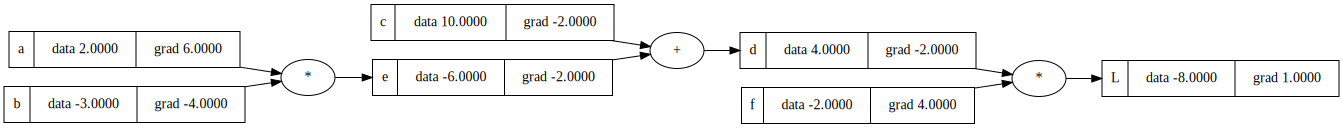

In [10]:
draw_dot(L)

In [9]:
# MANUAL BACKPROPAGATION

L.grad = 1.0
f.grad = 4.0
d.grad = -2.0

# CHAIN RULE:
# dL/dc = dL/dd * dd/dc
c.grad = d.grad * 1.0
# dL/de = dL/dd * dd/de
e.grad = d.grad * 1.0

# dL/db = dL/de * de/db
b.grad = e.grad * a.data
# dL/da = dL/de * de/da
a.grad = e.grad * b.data


In [18]:
def grad_check_with_numerical_derivative():
    h = 0.00001

    a = engine.Value(2.0, label='a')
    b = engine.Value(-3.0, label='b')
    c = engine.Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = engine.Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data

    a = engine.Value(2.0, label='a')
    b = engine.Value(-3.0, label='b')
    b.data += h
    c = engine.Value(10.0, label='c')
    e = a*b; e.label = 'e'
    # e.data += h
    d = e+c; d.label = 'd'
    # d.data += h
    f = engine.Value(-2.0, label='f')
    # f.data += h
    L = d*f; L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)

grad_check_with_numerical_derivative()

-4.000000000026205


## NEURON

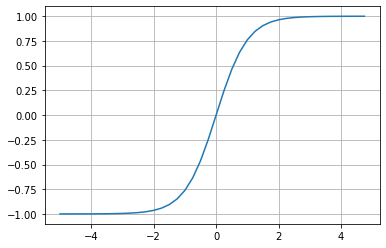

In [13]:
plt.plot(np.arange(-5, 5, 0.25), np.tanh(np.arange(-5, 5, 0.25))); plt.grid()

In [98]:
# inputs
x1 = engine.Value(2.0, label='x1')
x2 = engine.Value(0.0, label='x2')
# weights
w1 = engine.Value(-3.0, label='w1')
w2 = engine.Value(1.0, label='w2')
# bias
b = engine.Value(6.88, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

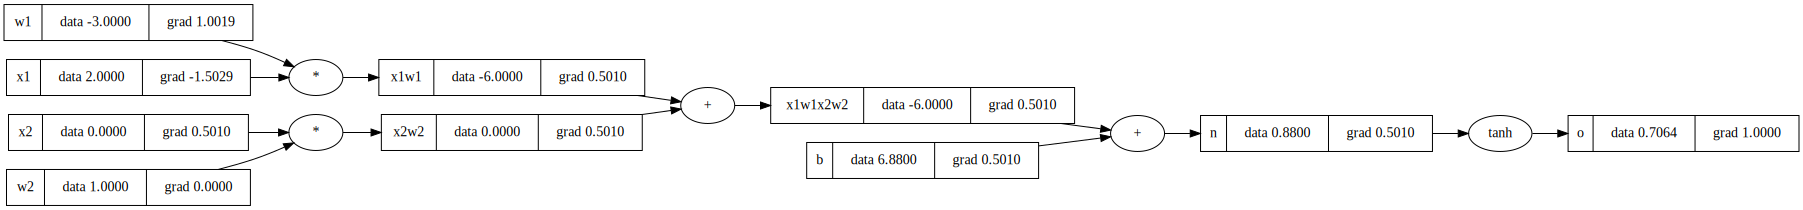

In [101]:
draw_dot(o)

In [84]:
# Manual backprop
o.grad = 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
b._backward()
x1w1._backward()
x2w2._backward()

In [100]:
o.backward()

## Breaking up Tanh

In [46]:
# inputs
x1 = engine.Value(2.0, label='x1')
x2 = engine.Value(0.0, label='x2')
# weights
w1 = engine.Value(-3.0, label='w1')
w2 = engine.Value(1.0, label='w2')
# bias
b = engine.Value(6.88, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2 + b; n.label='n'
# -----------
# o = n.tanh(); o.label='o'
e = (2*n).exp(); e.label = 'e'
o = (e - 1) / (e + 1); o.label='o'
# -----------

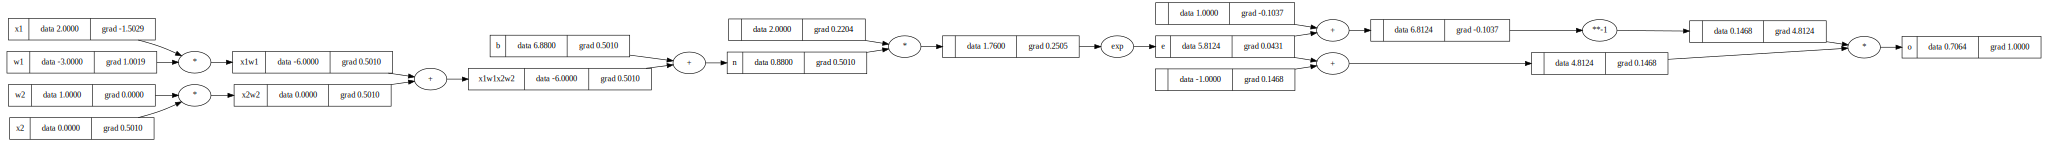

In [47]:
o.backward()
draw_dot(o)

## Do With PyTorch

In [48]:
import torch

In [54]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.88]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

o.backward()
print(o.data.item())

print('x1:', x1.grad.item())
print('w1:', w1.grad.item())
print('x2:', x2.grad.item())
print('w2:', w2.grad.item())

0.7064193777288968
x1: -1.5029149883073543
w1: 1.0019433255382362
x2: 0.5009716627691181
w2: 0.0
